# Estimación de parámetros de un activo financiero

In [1]:
#Loading libraries and functions.
from scripts.logNormalFunc import *

## Análisis exploratorio de los datos

Vamos a analizar de forma libiana los datos y en caso de necesitar alguna transformación para poder aplicar nuestro modelo procederemos con ello.

En primer lugar, establecemos la conexión con la base de datos de Yahoo Finance y vamos a descargar los datos del BBVA, es una empresa que opera en el sector retail bancario, lo que significa que ofrecen servicios como cuentas de ahorro, tarjetas de débito/crédito, productos de inversión, etc.

En la siguiente tabla, podemos ver los valores de los ultimos días de apertura y cierre, el valor máximo/mínimo en el día.

In [2]:
simbolo = "BBVA.MC"
bbva = yf.Ticker(simbolo)
print(bbva.info["longBusinessSummary"] + " " + bbva.info["website"])
df = bbva.history(period="max")
df[["Open", "High", "Low","Close"]].tail(10)

Banco Bilbao Vizcaya Argentaria, S.A., together with its subsidiaries, provides retail banking, wholesale banking, and asset management services. It offers current accounts; and demand, savings, overnight, time, term, and subordinated deposits. The company also provides loan products; deals in securities; and manages pension and investment funds. In addition, it offers credit cards; corporate and investment banking services; insurance products and services; and real estate services. The company provides its products through online and mobile channels. As of December 31, 2021, it operated through a network of 6,083 branches and 29,148 ATMs. It operates in Spain, Mexico, South America, the United States, Turkey, Asia, and rest of Europe. Banco Bilbao Vizcaya Argentaria, S.A. was founded in 1857 and is headquartered in Bilbao, Spain. https://www.bbva.com


,Open,High,Low,Close
Date,,,,
2022-11-23 00:00:00+01:00,5.517,5.559,5.465,5.536
2022-11-24 00:00:00+01:00,5.536,5.598,5.524,5.580
2022-11-25 00:00:00+01:00,5.590,5.644,5.572,5.641
2022-11-28 00:00:00+01:00,5.593,5.628,5.540,5.540
2022-11-29 00:00:00+01:00,5.561,5.663,5.525,5.624
2022-11-30 00:00:00+01:00,5.611,5.642,5.535,5.612
2022-12-01 00:00:00+01:00,5.640,5.665,5.564,5.566
2022-12-02 00:00:00+01:00,5.552,5.619,5.518,5.612
2022-12-05 00:00:00+01:00,5.582,5.612,5.544,5.554


Como vemos el conjunto de datos proporcionado en el índice del DataFrame tenemos la fecha en formato, año, mes, días y hora. Depués tenemos valores numéricos, como son el valor de apertura, el máximo, el mínimo y el cierre. En el siguiente gráfico, podemos ver los precios del BBVA desde el año 2000, se aprecia que al rededor del año 2006 obtuvo sus valores máximo y al rededor de los años 2008 y 2020 los valores mínimos, esto es algo que tiene sentido, ya que ambos momentos se estaba atravesando una crísis económica.

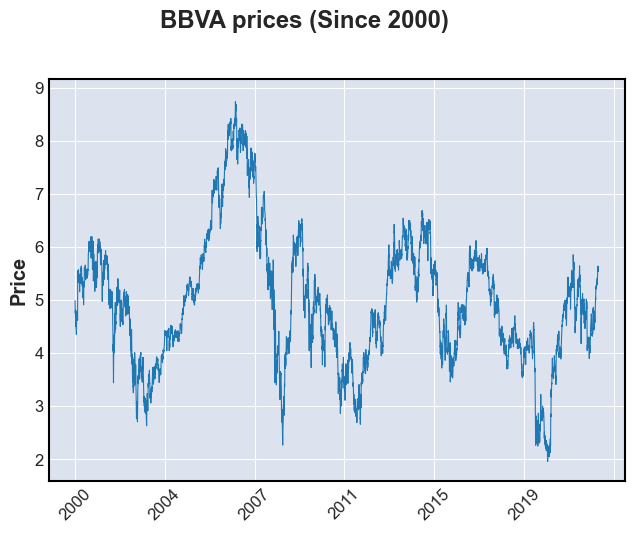

None

In [3]:
display(mpf.plot(df,type='line', title = "BBVA prices (Since 2000)", datetime_format = "%Y"))

Si nos fijamos en los valores tomados en los últimos 120 días, podemos ver como la tendencia desde mitad del mes de Junio es creciente y positiva, aunque no en todo el periodo ha sido así.

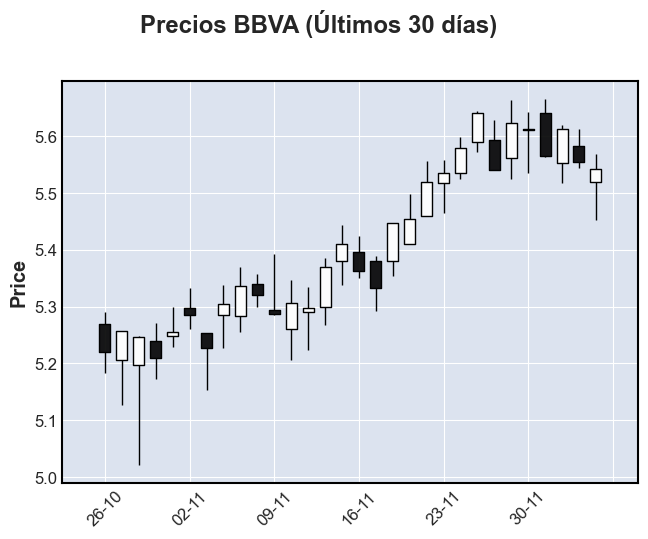

None

In [4]:
display(mpf.plot(df.iloc[len(df)-30:] ,type='candle', title = "Precios BBVA (Últimos 30 días)", datetime_format = "%d-%m" ))

## Modelo Log-Normal

En primer lugar, vamos a tomar un subconjunto de los datos, por ejemplo los ultimos 30 días. Además, solo cogeremos los datos de cierre.

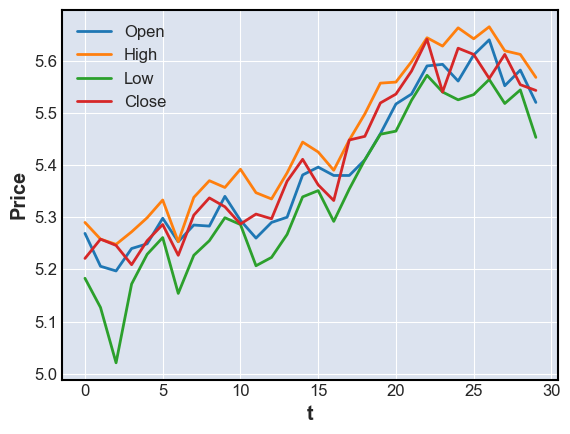

In [5]:
datos = df.iloc[len(df)-30:][["Open","High","Low","Close"]]
datos.index = range(0,len(datos))
ax = datos.plot()
ax.set_ylabel("Price")
ax.set_xlabel("t")
plt.show()

Como habíamos apreciado, tenemos una tendencia claramente positiva. Ahora vamos a calcular los estimadores para nuestra muestra de datos y eligiremos el mejor en función del error que presente.

### Cálculo de estimadores

Con las funciones definidas al principio del ejercicio, podemos calcular por el método de momentos y  máxima verosimilitud.

In [6]:
estimacionMomentos(datos)

{'mMME': Open     0.001636
 High     0.001794
 Low      0.001819
 Close    0.002108
 dtype: float64,
 'sMME': Open     0.007848
 High     0.007507
 Low      0.011644
 Close    0.009430
 dtype: float64}

In [7]:
estimacionMV(datos)

{'muE': Open     0.001581
 High     0.001735
 Low      0.001758
 Close    0.002039
 dtype: float64,
 'siE': Open     0.007580
 High     0.007259
 Low      0.011256
 Close    0.009127
 dtype: float64}

Ambos métodos nos dan resultados muy similares, además la media es un valor positivo, lo que va a provocar que el modelo tenga una tendencia positiva, que es lo que esperamos debido a la tendencia positiva de nuestros datos.

### Validación

Ambos métodos nos dan dado unos resultados similares, por lo que deberíamos someterlo a un proceso de validación de los datos. Para esto, vamos a utilizar la función creada anteriormente que nos devuelve el error cuadrático medio y el error absoluto porcentual.

In [8]:
valMom = pd.DataFrame(validacion(estimacionMomentos(datos), datos))
valMV = pd.DataFrame(validacion(estimacionMV(datos), datos))
valMNP = pd.DataFrame(validacion(estimacionMNP(datos), datos))

pd.concat([valMom, valMV,valMNP], keys=['M', 'Mv','MNP'])

ECM      MAPE
M   Open   0.027619  1.427041
    High   0.030300  1.561838
    Low    0.030715  1.602906
    Close  0.035600  1.849600
Mv  Open   0.026702  1.379672
    High   0.029300  1.510300
    Low    0.029679  1.548844
    Close  0.034424  1.788523
MNP Open   0.027109  1.400703
    High   0.029737  1.532809
    Low    0.029434  1.536047
    Close  0.034697  1.802706

Si nos fijamos en la tabla, vemos como el mejor resultado lo obtiene el método de máxima verosimilitud, por lo que será el que utilicemos a la hora de ajustar nuestro modelo. El motivo es bastante claro, a nivel error cuadrático medio, queremos el valor mas cercano a 0, ya que esto implicaría que las predicciones son exactamente iguales que el valor real. En cuanto al error absoluto porcentual, al igual que el ECM cuando menor sea es mejor, ya que es la suma de la diferencia en valor absoluto de nuestras predicciones y el valor real. Para saber si son errores aceptables, vamos a calcular el ECM y MAPE tomando la media muestral como prediccion, ya que establecería el método de predecir más básico y como consecuencia, establece un error base a mejorar.

ECM -> Open     0.1376
High     0.1399
Low      0.1513
Close    0.1406
dtype: float64
----
MAPE -> Open     2.2456
High     2.2942
Low      2.4725
Close    2.3633
dtype: float64%


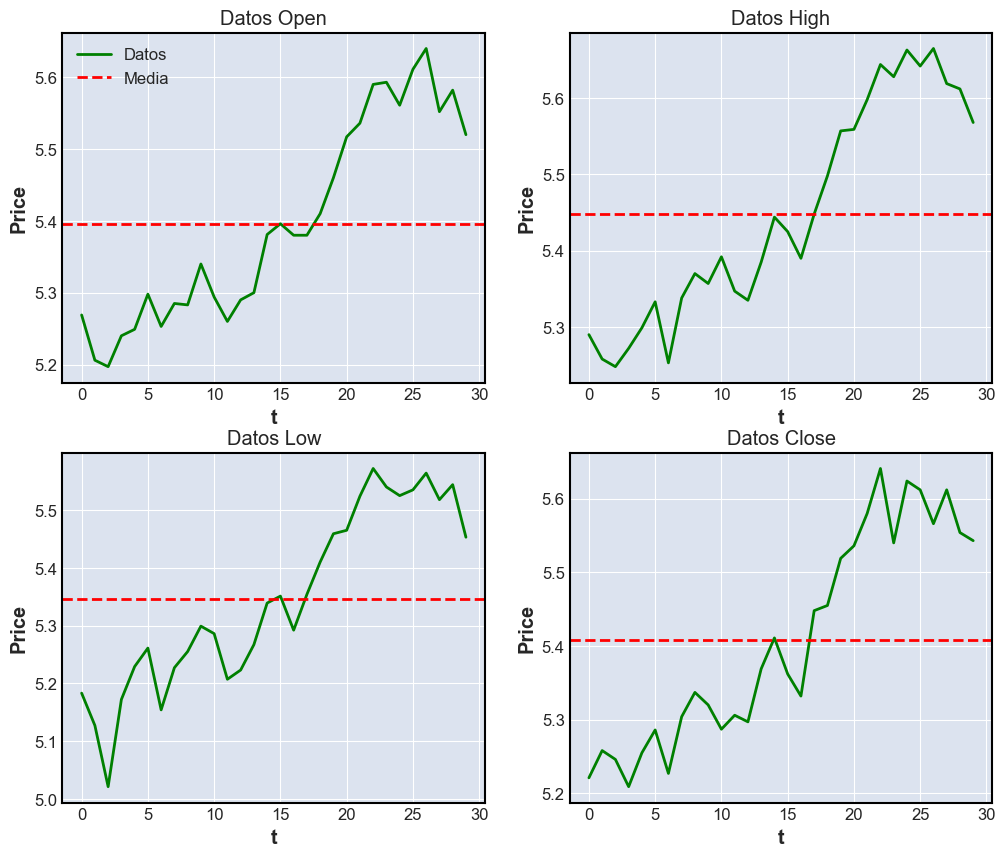

In [9]:
n = len(datos)
d = datos
m = np.mean(d)
ecm = np.sqrt((1/n)*(np.sum( (d-m)**2 )) )
mape = 100/n * np.sum(np.abs(d-m)/np.abs(d))
print( f"ECM -> {round(ecm,4)}\n----\nMAPE -> {round(mape,4)}%")

fig, ax = plt.subplots(2,2,figsize=(12, 10))

ax[0,0].plot(d["Open"], label = "Datos",color = "green")
ax[0,0].axhline(m[0], label = "Media",color = 'red',linestyle='dashed' )
ax[0,0].set_ylabel("Price")
ax[0,0].set_xlabel("t")
ax[0,0].set_title("Datos Open")
ax[0,0].legend()

ax[0,1].plot(d["High"],color = "green")
ax[0,1].axhline(m[1],color = 'red',linestyle='dashed' )
ax[0,1].set_ylabel("Price")
ax[0,1].set_xlabel("t")
ax[0,1].set_title("Datos High")

ax[1,0].plot(d["Low"],color = "green")
ax[1,0].axhline(m[2],color = 'red',linestyle='dashed' )
ax[1,0].set_ylabel("Price")
ax[1,0].set_xlabel("t")
ax[1,0].set_title("Datos Low")

ax[1,1].plot(d["Close"],color = "green")
ax[1,1].axhline(m[3],color = 'red',linestyle='dashed' )
ax[1,1].set_ylabel("Price")
ax[1,1].set_xlabel("t")
ax[1,1].set_title("Datos Close")


plt.show()

Vemos como el ECM es mucho mayor y el MAPE también, por lo que podemos aceptar como validos nuestros errores. Si el error fuese peor que esta estimación con media, entonces el modelo no estaría mejorando los resultados y tendríamos que descartarlo.

### Ajuste del modelo

ECM -> Open     0.026702
High     0.029300
Low      0.029679
Close    0.034424
dtype: float64
- - - - - - - 
MAPE -> Open     1.379672
High     1.510300
Low      1.548844
Close    1.788523
dtype: float64%
- - - - -  - 
Prediccion a 3 días.


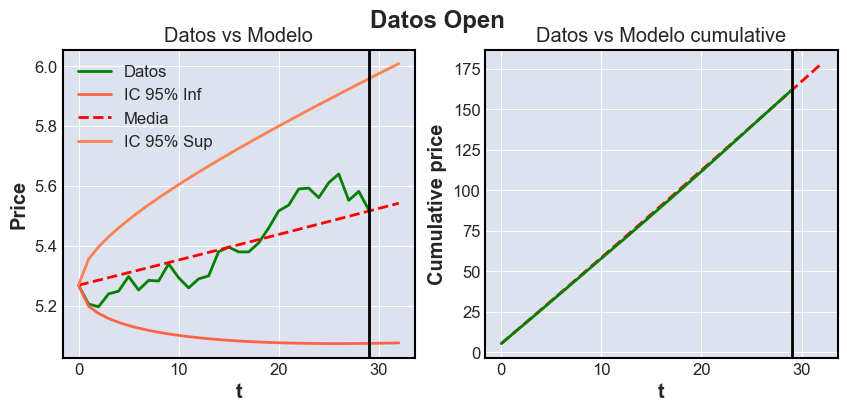

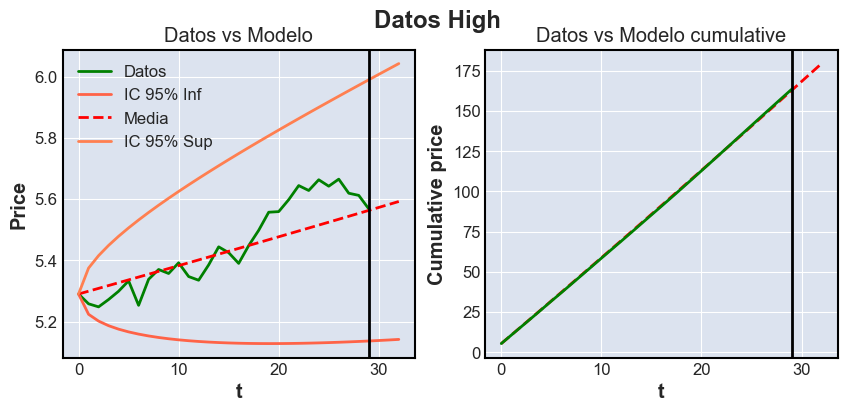

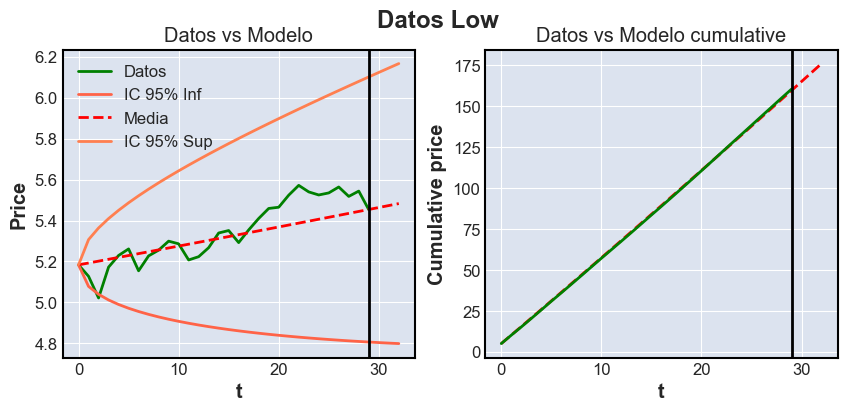

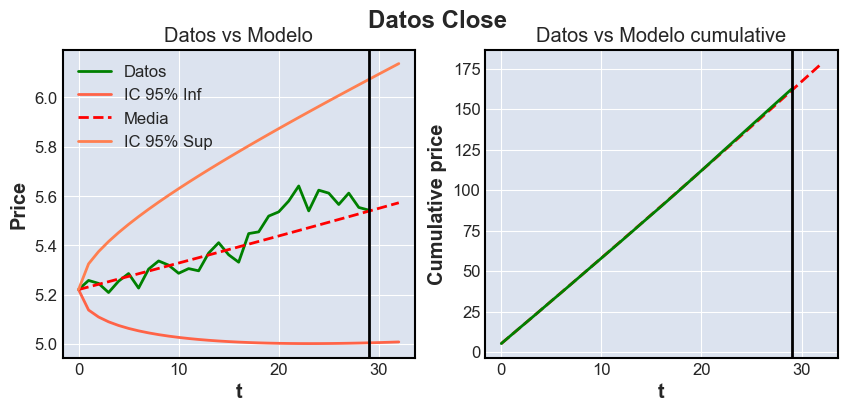

In [10]:
graficar(datos, estimacionMV(datos), 3)

Para calcular la tabla, obtenemos la media y desviación típica en cada momento de tiempo, cuando queremos hacer predicciones escogemos un t mayor que nuestro rango, para nuestro ejemplo t=0,...,29 , por lo que para obtener una predicción a 3 días, escogemos t = 30,31,32 y obtenemos estos valores. En cuanto al intervalo de confianza, calculamos el valor de la media +/- 1.96*sigma para cada instante de tiempo.

## Apendix: Definición de las funciones que vamos a utilizar y carga de librerías

En python hay multitud de librerías que podemos utilizar, en este caso utilizaremos librerías standar para el analísis de datos y acceder a la base de datos de Yahoo Finance.
Además, vamos a definir una serie de funciones para proceder a ajustar un modelo log-normal.

El modelo Log-Normal se puede describir matemáticamente como:
$$ 
    \begin{cases}
    dS(t) = \mu S(t) + \sigma S(t)dW(t)\ \ donde \  \mu \in \mathbb{R} \ y \ \sigma >0, \\
    S(0) = s_0
    \end{cases} 
$$
Aplicando el Lema de Ito y resolviendo la EDE, obtenemos que $S(t) = s_0 \cdot e^{(\mu - \frac{1}{2}\sigma ^2)t + \sigma W(t) }$

### Librerías

In [11]:
#pip install yfinance   -> Con esta librería podemos conectarnos a los datos de Yahoo Finance.
#pip install pandas     -> Librería por excelencia para el manejo de DataFrames con python.
#pip install numpy      -> Librería por excelencia para el manejo de arrays de datos con python.
#pip install mplfinance -> Librería para hacer candle plots.
#pip install math       -> Librería por excelencia para utilizar funciones matemáticas.
#pip install datetime   -> Librería por excelencia para manejar timestamps.
#pip install matplotlib.pyplot -> Librería por excelencia para graficar.

import yfinance as yf  
import pandas as pd 
import numpy as np
import mplfinance as mpf
import datetime as dt
from math import exp

import matplotlib.pyplot as plt

### Funciones

####  Media

Aplicando el operador esperanza se obtiene la siguiente expresión: $$ \mathbb{E}[S(t)] = s_0 \cdot e^{\mu t}, $$ Esto lo podemos programar de la siguiente manera:

In [12]:
def media(datos,mu,t = None):
        """
        La siguiente función nos devuelve el media del modelo Log-Normal en el instate t:
        Input:
            - datos(List[Number])   : Datos a analizar.
            - mu(Number)            : Media muestral.
            - t (Number)            : Vector de tiempos o el instante t. (Valor opcional, si no se rellena, devuelve en cada instante de t)
        Output:
            - eS(List[Number])      : Vector de medias de la solución en todos los instantes o media de la solución en el instante t.
        """
        from math import exp
        import pandas as pd 

        s0 = datos.iloc[0]
        eS = pd.DataFrame(columns=datos.iloc[0].index)
        if t:
            eS = eS.append(pd.DataFrame(s0*list(map(exp,mu*t))).transpose(),ignore_index=True)
        else:
            for t in range(len(datos)):
                eS = eS.append(pd.DataFrame(s0*list(map(exp,mu*t))).transpose(),ignore_index=True)
        return(eS)

#### Desviación típica

Podemos calcular la desviación típica de la siguiente manera: $$ \sqrt{ \mathbb{V}[S(t)]} = \sqrt{\mathbb{E}[S(t)^2] - \mathbb{E}[S(t)]^2 }= \sqrt{ s_0^2 \cdot e^{2 \mu t} \cdot (e^{\sigma^2 t} - 1)}, $$ Esto lo podemos programar de la siguiente manera:

In [13]:
def desvTipica(datos ,mu, sigma, t = None):
    """
    La siguiente función nos devuelve la desviación típica del modelo Log-Normal en el instate t:
    Input:
        - datos(List[Number])   : Datos a analizar.
        - mu(Number)            : Media muestral.
        - sigma(Number)         : Desviación típica muestral.
        - t (Number)            : Vector de tiempos o el instante t. (Valor opcional, si no se rellena, devuelve en cada instante de t)
    Output:
        - eS(List[Number])       : Vector desviación típica la solución en todos los instantes o desviación típica de la solución en el instante t.
    """
    from math import exp, sqrt
    import numpy as np 
    import pandas as pd 

    s0 = datos.iloc[0]
    eS = pd.DataFrame(columns=datos.iloc[0].index)
    if t:
        eS = eS.append(pd.DataFrame(list(map(sqrt,(s0**2)*list(map(exp,2*mu*t))*list(map(lambda x : exp(x) - 1, (sigma**2)*t)))),index = datos.columns).transpose(),ignore_index=True)
    else:
        for t in range(len(datos)):
            eS = eS.append(pd.DataFrame(list(map(sqrt,(s0**2)*list(map(exp,2*mu*t))*list(map(lambda x : exp(x) - 1, (sigma**2)*t)))),index = datos.columns).transpose(),ignore_index=True)
    return(eS)

#### Método de estimación de momentos estadísticos

In [14]:
def estimacionMomentos(datos):
    """
    La siguiente función nos devuelve mu y sigma obtenidos por el método de los momentos,
    Este método se basa en calcular la media y varianza muestral de la diferencia de logaritmos de nuestros datos, es decir,
    la diferencia de S(t) evaluado en i+1 e i tomando logaritmos. Con esta diferencia obtenemos los valores que nos da el método:
    Input:
        - datos(List[Number])   : Datos a analizar.
    Output:
        - Dict[Number]          : Diccionario con los datos de la media y la desviación típica que nos da el método.
    """
    import numpy as np
    import pandas as pd
    import datetime as dt

    try:
        dt = (datos.index[1] - datos.index[0]).days
        u = np.log(datos).diff()
        uM = u.mean()
        uV = u.std()**2
        
        return( {"mMME" : (uM + uV/2)/dt , "sMME" : np.sqrt(uV/dt) }   )
    except:
        dt = 1
        u = np.log(datos).diff()
        uM = u.mean()
        uV = u.std()**2
        
        return( {"mMME" : (uM + uV/2)/dt , "sMME" : np.sqrt(uV/dt) }   )

#### Método de estimación de máxima verosimilitud

In [15]:
def estimacionMV(datos):
    """
    La siguiente función nos devuelve mu y sigma obtenidos por el método de máxima verosimilitud,
    Este método se basa en maximizar la función de verosimilitud.
    Input:
        - datos(List[Number])   : Datos a analizar.
    Output:
        - Dict[Number]          : Diccionario con los datos de la media y la desviación típica que nos da el método.
    """
    import numpy as np
    import pandas as pd
    import datetime as dt
    n = len(datos)
    try:
        dt = (datos.index[1] - datos.index[0]).days

        muE = (1/(n*dt))*np.sum((datos/datos.shift()) -1)
        siE = np.sqrt((1/(n*dt))*np.sum(((datos/datos.shift()) -1- muE*dt)**2 ))
        
        return( {"muE" : muE  ,"siE" : siE})
    except:
        dt = 1

        muE = (1/(n*dt))*np.sum((datos/datos.shift()) -1)
        siE = np.sqrt((1/(n*dt))*np.sum(((datos/datos.shift()) -1- muE*dt)**2 ))
        
        return( {"muE" : muE  ,"siE" : siE})

#### Método de estimación de momentos no paramétrico

In [16]:
def estimacionMNP(datos):
    """
    La siguiente función nos devuelve mu y sigma obtenidos por el método de momentos no paramétrico.
    Input:
        - datos(List[Number])   : Datos a analizar.
    Output:
        - Dict[Number]          : Diccionario con los datos de la media y la desviación típica que nos da el método.
    """
    import numpy as np
    import pandas as pd
    import datetime as dt
    n = len(datos)
    
    try:
        dt = (datos.index[1] - datos.index[0]).days
        muE = (1/(dt))*(np.sum(datos.diff())/np.sum(datos[0:(n-1)]))
        siE = np.sqrt((1/(dt))*(np.sum((datos.diff())**2)/np.sum((datos[0:(n-1)])**2)))
        
        return( {"muMnp" : muE  ,"siMnp" : siE})
    except:
        dt = 1

        muE = (1/(dt))*(np.sum(datos.diff())/np.sum(datos[0:(n-1)]))
        siE = np.sqrt((1/(dt))*(np.sum((datos.diff())**2)/np.sum((datos[0:(n-1)])**2)))
        
        return( {"muMnp" : muE  ,"siMnp" : siE})

#### Errores

In [17]:
def errores(datos, modelo):
    """
    La siguiente función nos devuelve los erroes cuadrático medio y absoluto porcentual del modelo ajustado.
    Input:
        - datos(List[Number])   : Datos a analizar.
        - modelo(List[Number])  : Datos que nos devuelve nuestro modelo.
    Output:
        - Dict                  : Diccionario que nos devuelve los valores de error.
    """
    import numpy as np
    import pandas as pd

    d = np.log(datos.iloc[0])
    m = np.log(modelo)

    n = len(datos)

    ecm = np.sqrt((1/n)*(np.sum( (d-m)**2 )) )

    mape = 100/n * np.sum(np.abs(d-m)/np.abs(d))

    return({"ECM": ecm , "MAPE" : mape})

#### Validación del modelo

In [18]:
def validacion(estimacion, datos):
    """
    La siguiente función nos devuleve los errores cometidos al utilizar cierto estimador. Se complementa con la función error.
    Input:
        - estimacion(Dict[Number]) : Diccionario que contiene la media y la sigma estimada con cierta función de estimación.
        - datos(List[Number])   : Datos a analizar.
    Output:
        - Dict                  : Diccionario que nos devuelve los valores de error.
    """
    mu = [estimacion[k] for k in estimacion.keys() if k in ("mMME","muE","muMnp")][0]
    sigma = [estimacion[k] for k in estimacion.keys() if k not in ("mMME","muE","muMnp")][0]

    mm = media(datos,mu)

    return(errores(datos, mm))

#### Predicciones

In [19]:
def predecir(datos, est, t):
    """
    La siguiente función nos devuleve la tabla con los valores obtenidos en nuestro modelo. Además contiene la prediccion en las ultimas t filas.
    Input:
        - datos(List[Number])   : Datos a analizar.
        - est(Dict[Number])     : Diccionario que contiene la media y la sigma estimada con cierta función de estimación.
        - t (Number)            : Numero de periodos que queremos estimar.
    Output:
        - tabla(DataFrame)      : Diccionario que nos devuelve los valores de error.
    """
    mu = [est[k] for k in est.keys() if k in ("mMME","muE","muE")][0]
    sigma = [est[k] for k in est.keys() if k not in ("mMME","muE","muE")][0]

    val = validacion(est, datos)

    muP = media(datos,mu)
    for i in range(0,t):
        muP = muP.append(media(datos,mu,len(datos)+i),ignore_index=True)

    sigmaP = desvTipica(datos,mu, sigma)
    for i in range(0,t):
        sigmaP = sigmaP.append(desvTipica(datos,mu,sigma,len(datos)+i),ignore_index=True)


    p25 = pd.DataFrame(np.array(muP)-1.96*np.array(sigmaP), columns = datos.columns)
    p975 = pd.DataFrame(np.array(muP) + 1.96*np.array(sigmaP), columns = datos.columns)
        


    print( f"ECM -> {val['ECM']}\n- - - - - - - \nMAPE -> {val['MAPE']}%\n- - - - -  - \nPrediccion a {t} días.")

    return(p25,muP,p975,sigmaP)

#### Gráficos

In [20]:
def graficar(datos, est, t):
    """
    La siguiente función nos grafica los resultados del modelo
    Input:
        - datos(List[Number])   : Datos a analizar.
        - est(Dict[Number])     : Diccionario que contiene la media y la sigma estimada con cierta función de estimación.
        - t (Number)            : Numero de periodos que queremos estimar.
    Output:
        - Información del modelo + Gráficos
    """
    p25,muP,p975,sigmaP = predecir(datos, est, t)

    for col in datos.columns:
        fig,(ax1,ax2) = plt.subplots(1,2,figsize = (10,4))
        ax1.plot(datos[col], label = "Datos", color = 'green')
        ax1.plot(p25[col], label = "IC 95% Inf", color = 'tomato')
        ax1.plot(muP[col], label = "Media", color = 'red' ,linestyle= 'dashed')
        ax1.plot(p975[col], label = "IC 95% Sup", color = 'coral')
        ax1.axvline(x = len(datos)-1 , color = 'black') 
        ax1.legend()

        ax1.set_ylabel("Price")
        ax1.set_xlabel("t")
        
        ax1.set_title("Datos vs Modelo")


        ax2.plot(muP[col].cumsum(), label = "Media", color = 'red' ,linestyle= 'dashed')
        ax2.plot(datos[col].cumsum(), label = "Datos", color = 'green')
        ax2.axvline(x = len(datos)-1 , color = 'black') 

        ax2.set_ylabel("Cumulative price")
        ax2.set_xlabel("t")
        
        ax2.set_title("Datos vs Modelo cumulative")

        fig.suptitle("Datos " + col)

        plt.show()
